In [10]:
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader

# Fetch historical stock data
ticker = 'AAPL'
data = yf.download(ticker, start='2015-01-01', end='2023-01-01')

# Add trading volume and a simple moving average as features
data['SMA'] = data['Close'].rolling(window=20).mean()
data['Volume'] = data['Volume'].astype(float)

# Drop NaN values
data.dropna(inplace=True)

# Display the first few rows
print(data.head())

[*********************100%***********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close  \
Date                                                                
2015-01-30  29.600000  30.000000  29.212500  29.290001  26.119574   
2015-02-02  29.512501  29.792500  29.020000  29.657499  26.447285   
2015-02-03  29.625000  29.772499  29.402500  29.662500  26.451757   
2015-02-04  29.625000  30.127501  29.577499  29.889999  26.654629   
2015-02-05  30.004999  30.057501  29.812500  29.985001  26.844879   

                 Volume        SMA  
Date                                
2015-01-30  334982000.0  27.660375  
2015-02-02  250956400.0  27.776625  
2015-02-03  207662800.0  27.931625  
2015-02-04  280598800.0  28.097875  
2015-02-05  168984800.0  28.250250  


In [11]:


# Normalize the features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Close', 'Volume', 'SMA']])



In [12]:

class StockDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, index):
        x = self.data[index:index + self.seq_length]
        y = self.data[index + self.seq_length: index + self.seq_length + 1, 0]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [13]:
seq_length = 5

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create Dataset objects for train and test sets
train_dataset = StockDataset(train_data, seq_length)
test_dataset = StockDataset(test_data, seq_length)

# Create DataLoaders for train and test sets
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [14]:


class AttentionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(AttentionLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attention = nn.Linear(hidden_size, 1)
        self.fc_p = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(p=0.6)

    def forward(self, x):
        lstm_out, (h_n, c_n) = self.lstm(x)
        attention_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context_vector = torch.bmm(attention_weights.transpose(1, 2), lstm_out)

        # Apply dropout
        context_vector = (self.dropout(context_vector))


        output_price = self.fc_p(context_vector.squeeze(1))
        return output_price, attention_weights  # Return both output and attention weights

Epoch [10/200], Loss: 0.0679
Epoch [20/200], Loss: 0.0379
Epoch [30/200], Loss: 0.0306
Epoch [40/200], Loss: 0.0246
Epoch [50/200], Loss: 0.0179
Epoch [60/200], Loss: 0.0106
Epoch [70/200], Loss: 0.0054
Epoch [80/200], Loss: 0.0054
Epoch [90/200], Loss: 0.0056
Epoch [100/200], Loss: 0.0043
Epoch [110/200], Loss: 0.0047
Epoch [120/200], Loss: 0.0043
Epoch [130/200], Loss: 0.0036
Epoch [140/200], Loss: 0.0043
Epoch [150/200], Loss: 0.0039
Epoch [160/200], Loss: 0.0034
Epoch [170/200], Loss: 0.0034
Epoch [180/200], Loss: 0.0031
Epoch [190/200], Loss: 0.0032
Epoch [200/200], Loss: 0.0027


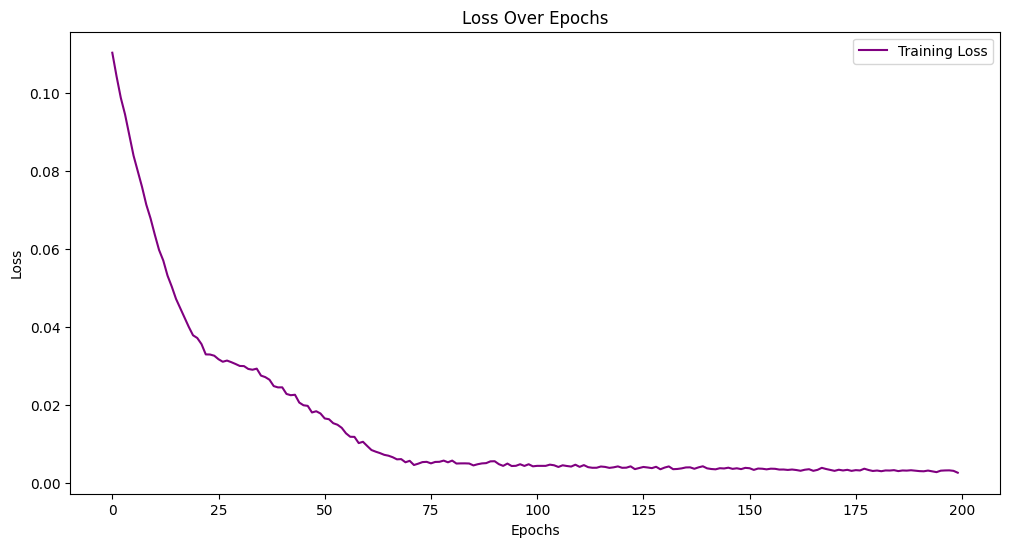

In [17]:
# Training setup
input_size = 3#X_train.shape[2]
hidden_size = 64*1
num_layers = 1

model = AttentionLSTM(input_size, hidden_size, num_layers)
# model = model.cuda()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 200

losses = []
attention_weights_list = []
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    total_loss = 0
    for i, (batch_x, batch_y) in enumerate(train_loader):

        optimizer.zero_grad()
        # batch_x = batch_x.cuda()
        # batch_y = batch_y.cuda()

        # Forward pass
        price_pred, attention_weights = model(batch_x)

        loss = criterion(price_pred, batch_y)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Track the total loss
        total_loss += loss.item()
    losses.append(total_loss / len(train_loader))
    attention_weights_list.append(attention_weights.cpu().detach().numpy())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {total_loss:.4f}')


# Plot loss over epochs
plt.figure(figsize=(12, 6))
plt.plot(losses, color='purple', label='Training Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([10, 1])


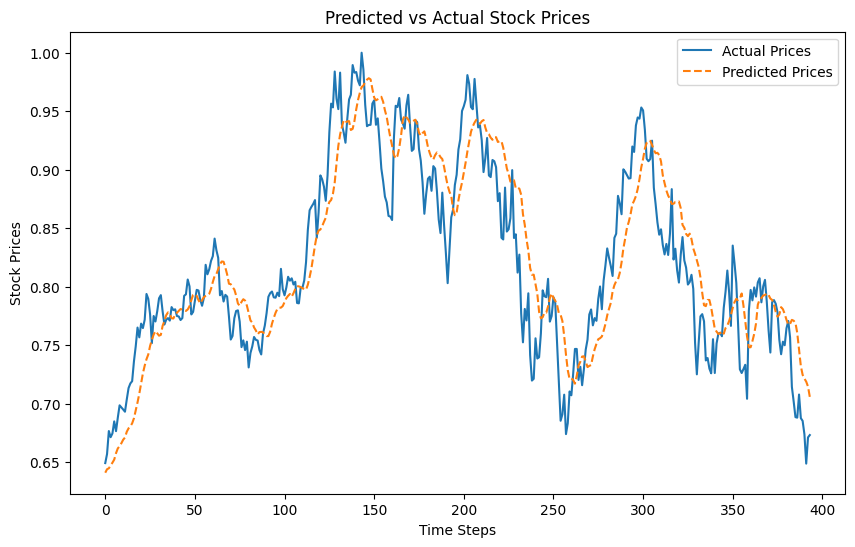

In [19]:
model.eval()

all_preds = []
all_actuals = []
all_attention_weights_test = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        # batch_x = batch_x.cuda()
        # batch_y = batch_y.cuda()
        print(batch_y.shape)
        price_pred, attention_weights = model(batch_x)
        all_preds.append(price_pred.cpu().numpy())
        all_actuals.append(batch_y.cpu().numpy())
        all_attention_weights_test.append(attention_weights.squeeze(-1).cpu().numpy())

# Convert the lists to arrays for further evaluation or visualization
all_preds = np.concatenate(all_preds)
all_actuals = np.concatenate(all_actuals)


plt.figure(figsize=(10, 6))
plt.plot(all_actuals.flatten(), label='Actual Prices')
plt.plot(all_preds.flatten(), label='Predicted Prices', linestyle='dashed')
plt.title('Predicted vs Actual Stock Prices')
plt.xlabel('Time Steps')
plt.ylabel('Stock Prices')
plt.legend()
plt.show()

In [22]:
def plot_attention_weights(attention_weights, seq_idx=0):
    """
    Visualizes attention weights for a specific sequence from the test set.

    Args:
        attention_weights (np.array): Attention weights for all sequences.
        seq_idx (int): Index of the sequence to visualize.
    """
    # Extract attention weights for the specified sequence
    attn_weights_seq = attention_weights  # Squeeze to remove extra dimensions

    # Plot the attention weights as a heatmap
    plt.figure(figsize=(12, 4))
    plt.imshow(attn_weights_seq.T, cmap='coolwarm', aspect='auto')  # Use transpose for better orientation
    plt.colorbar(label='Attention Score')
    plt.title(f'Attention Weights for Test Sequence')
    plt.xlabel('Testing Instances')
    plt.ylabel('Attention Score')
    plt.show()

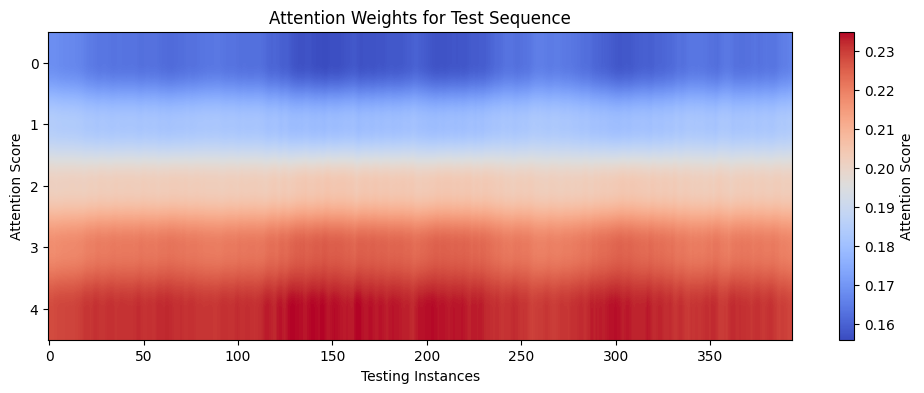

In [23]:
plot_attention_weights(np.concatenate(all_attention_weights_test, axis=0))